In [1]:
### from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [2]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [3]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../../../code/')  # to be replaced!

import utils as ut
import plots as pt

SyntaxError: invalid syntax (utils.py, line 36)

In [7]:
# %%javascript
# var nb = IPython.notebook;
# var kernel = IPython.notebook.kernel;
# var command = "NOTEBOOK_NAME = '" + nb.base_url + nb.notebook_path + "'";
# kernel.execute(command);

In [8]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'decoding_around_onset'

In [9]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
#load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [10]:
folder = './autorestore/preprocessing'
for var in ('time_ax', 'traces', 'events', 'areas', 'cycles',
            'is_rewardt', 'is_CSmt', 'CYCLE_START', 'CS_DURATION', 'DELAY'): 
    exec('%s = ut.load_variable(\'%s\', folder=\'%s\')'%(var, var, folder))
    
folder = './autorestore/decoding_odors/'
for var in ('labels',): 
    exec('%s = ut.load_variable(\'%s\', folder=\'%s\')'%(var, var, folder))

In [11]:
delta_t0 = 1

t_start0 = -5  # sec
t_stop0 = 11  # sec

# Shape of the following is (N_time_bins, N_patterns, N_cells)
patterns_tb = np.r_[[ut.extract_activity(time_ax, events, cycles, CYCLE_START, i*delta_t0, (i+1)*delta_t0,
                                      offset=t_start0)
                     for i in xrange(int((t_stop0-t_start0)/delta_t0))]]

# Shape of the following is (N_time_bins, N_patterns)
# labels_tb = np.r_[[extract_activity(time_ax, labels_time_ax, cycles, CYCLE_START, i*delta_t, (i+1)*delta_t, offset=-3)
#                      for i in xrange(int(10./delta_t))]]


In [12]:
from sklearn.svm import LinearSVC

In [29]:
decodor = LinearSVC()

# which_trials = labels>1  # only flower and banana
which_trials = [True] * len(labels)  # all odors and air
# which_trials = (labels==1) * (labels==5)  # only air and banana

labels_tb = np.r_[[[l]*patterns_tb.shape[0] for l in labels]].T
from sklearn.model_selection import cross_val_score, LeaveOneOut
scores = []
for i, (p, l) in enumerate(zip(patterns_tb, labels_tb)):
    if i ==1:
        print p[which_trials].shape
    # for every time bin
    scores.append(cross_val_score(decodor, p[which_trials], l[which_trials], cv=LeaveOneOut()))
# scores_tb3.append(scores_tb3)
scores = np.r_[scores]

(120, 53)


In [15]:
print (scores[0])

[ 1.  1.  1.  0.  1.  1.  0.  0.  1.  1.  0.  0.  0.  0.  1.  1.  0.  0.
  0.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  0.  0.  0.  1.  0.  1.  0.
  1.  0.  0.  0.  1.  0.  1.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  1.  0.  1.  1.  0.  1.  1.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  0.  1.  0.  1.  1.  1.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  1.  1.  1.  1.  0.  1.  1.  1.  0.  0.
  0.  1.  1.  1.  1.  0.  1.  1.  0.  0.  0.  0.]


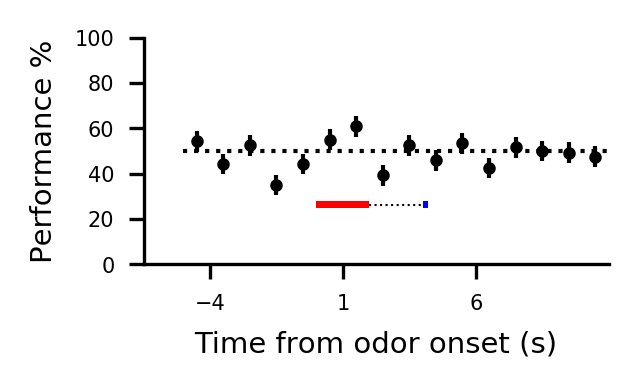

In [17]:
fig, ax = pl.subplots(1, 1, figsize=(2, 1))

t = np.arange(t_start0, t_stop0, delta_t0)
# ax.fill_between(t+np.diff(t)[0]/2.,
#                 (scores.mean(1) + np.std(scores, 1))*100,
#                 (scores.mean(1) - np.std(scores, 1))*100,
#                 lw=0, color='0.8')
ax.plot(t+np.diff(t)[0]/2., scores.mean(1)*100, 'ko', lw=.5, zorder=19,ms=2)
m = scores.mean(1)*100
s = np.std(scores, 1)*100 / np.sqrt(scores.shape[1]-1)
ax.errorbar(t+np.diff(t)[0]/2., m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
ax.set_ylim(0, 100)
ax.set_xlim(-6.5, 11)
ax.set_xticks(np.arange(t_start0+1, t_stop0, 5))
ax.hlines(50, t_start0, t_stop0, color='k', lw=1, linestyles='dotted')
# ax.step(t, scores_tb3.mean(1), lw=.5, zorder=19, where='post')
# ax.vlines(t, 0, 100, zorder=0, lw=0.5, color='0.8')
pt.nicer_plot(ax)
ax.set_xlabel('Time from odor onset (s)')
ax.set_ylabel('Performance %')
pt.plot_period_bar(ax, 25, start_end=(0, 2), color='r', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
pt.plot_period_bar(ax, 25, start_end=(4, 4.2), color='b', delta_y=3)
ax.hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')



# fig.savefig('img/proposal_decoding_timebased.svg')

In [13]:
save_workspace(db)

Could not store variable 'os'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'sys'. Skipping...
